## Impact of E-waste Pollutant Exposure on Renal Injury and Oxidative Stress  Biomarkers: Evidence from Causal Machine Learning

In [1]:
import dowhy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from dowhy.gcm.influence import arrow_strength, intrinsic_causal_influence
import networkx as nx
import dowhy.gcm as gcm
import scipy.stats as stats


data = pd.read_csv('NGAL.csv', encoding='gbk')

## STEP.1 Remove the outliers.

In [2]:
column = data['NGAL']

Q1 = column.quantile(0.25)
Q3 = column.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

filtered_data = data[(column >= lower_bound) & (column <= upper_bound)]
data_target=filtered_data[['Gender',  'Age', 'Smoking', 'Occupation', 'Village', 'Σ6NFRs',
                           'Σ11mVOCs', 'Σ7PAAs', 'Σ8BPs', 'Σ7OH-PAHs', 'Σ10mPAEs', 'Σ7mOPFRs',
                           'Σ3LMetals', 'Σ7TMetals', 'Σ9HMetals', 'NGAL']]

## STEP.2 Develop a structural causal model (SCM).

In [3]:
treatment_var_ori = 'Σ7PAAs'
treatment_var = 'Σ7PAAs'
other_var = ['Σ11mVOCs',  'Σ6NFRs',   'Σ10mPAEs', 'Σ7OH-PAHs', 'Σ8BPs',  'Σ7mOPFRs' , 'Σ3LMetals',  'Σ7TMetals', 'Σ9HMetals']
outcome_var = 'NGAL'
covariates = ['Gender',  'Age', 'Smoking', 'Occupation', 'Village']

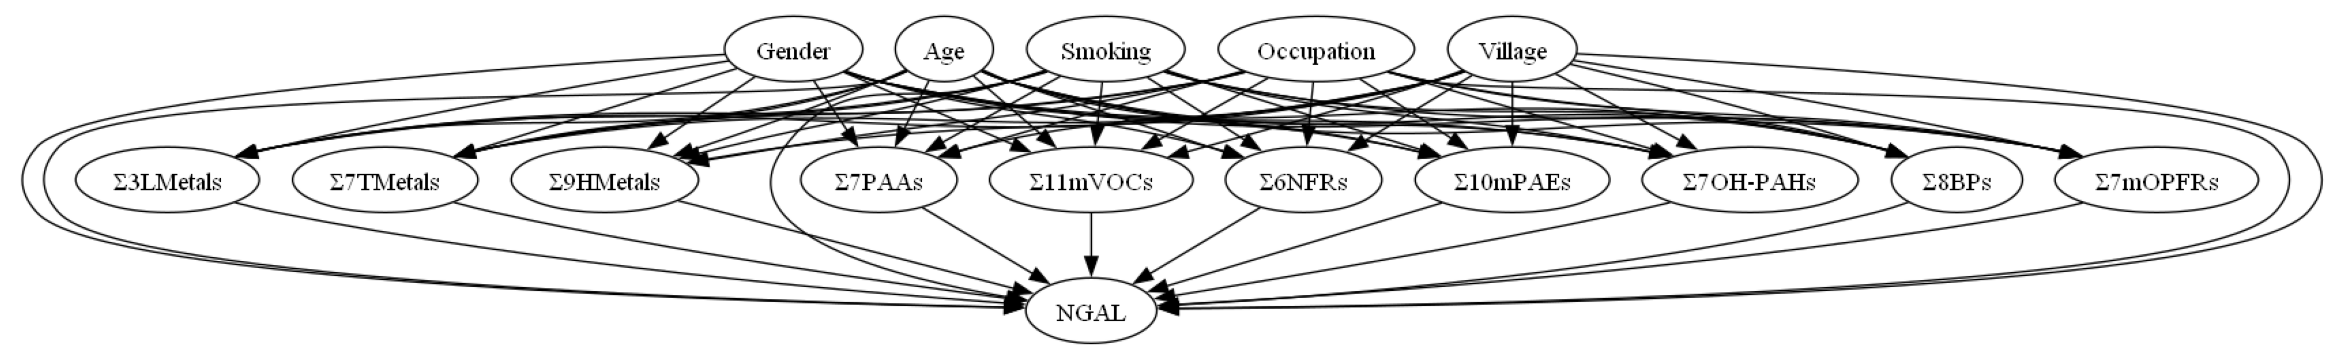

Fitting causal mechanism of node Σ9HMetals: 100%|██████████████████████████████████████| 16/16 [00:00<00:00, 18.13it/s]


In [4]:
causal_graph = nx.DiGraph([

    ('Gender', outcome_var),
    ('Age', outcome_var),
    ('Smoking', outcome_var),
    ('Occupation', outcome_var),
    ('Village', outcome_var), 
    (treatment_var, outcome_var),                         
    ("Σ11mVOCs", outcome_var),
    ("Σ6NFRs", outcome_var),
    ("Σ10mPAEs", outcome_var),
    ("Σ7OH-PAHs", outcome_var),
    ("Σ8BPs", outcome_var),
    ("Σ7mOPFRs", outcome_var),
    ("Σ3LMetals", outcome_var),
    ("Σ7TMetals", outcome_var),
    ("Σ9HMetals", outcome_var),       
    ('Gender', treatment_var),
    ('Age', treatment_var),
    ('Smoking', treatment_var),
    ('Occupation', treatment_var),
    ('Village', treatment_var),                     
    ("Gender","Σ11mVOCs"),
    ("Age","Σ11mVOCs"),
    ("Smoking","Σ11mVOCs"),
    ("Occupation","Σ11mVOCs"),
    ("Village","Σ11mVOCs"),
    ("Gender","Σ6NFRs"),
    ("Age","Σ6NFRs"),
    ("Smoking","Σ6NFRs"),
    ("Occupation","Σ6NFRs"),
    ("Village","Σ6NFRs"),
    ("Gender","Σ10mPAEs"),
    ("Age","Σ10mPAEs"),
    ("Smoking","Σ10mPAEs"),
    ("Occupation","Σ10mPAEs"),
    ("Village","Σ10mPAEs"),
    ("Gender","Σ7OH-PAHs"),
    ("Age","Σ7OH-PAHs"),
    ("Smoking","Σ7OH-PAHs"),
    ("Occupation","Σ7OH-PAHs"),
    ("Village","Σ7OH-PAHs"),
    ("Gender","Σ8BPs"),
    ("Age","Σ8BPs"),
    ("Smoking","Σ8BPs"),
    ("Occupation","Σ8BPs"),
    ("Village","Σ8BPs"),
    ("Gender","Σ7mOPFRs"),
    ("Age","Σ7mOPFRs"),
    ("Smoking","Σ7mOPFRs"),
    ("Occupation","Σ7mOPFRs"),
    ("Village","Σ7mOPFRs"),
    ("Gender","Σ3LMetals"),
    ("Age","Σ3LMetals"),
    ("Smoking","Σ3LMetals"),
    ("Occupation","Σ3LMetals"),
    ("Village","Σ3LMetals"),
    ("Gender","Σ7TMetals"),
    ("Age","Σ7TMetals"),
    ("Smoking","Σ7TMetals"),
    ("Occupation","Σ7TMetals"),
    ("Village","Σ7TMetals"),
    ("Gender","Σ9HMetals"),
    ("Age","Σ9HMetals"),
    ("Smoking","Σ9HMetals"),
    ("Occupation","Σ9HMetals"),
    ("Village","Σ9HMetals") ])

plt.figure(figsize=(30, 30))
gcm.util.plot(causal_graph)

causal_model = gcm.StructuralCausalModel(causal_graph)
causal_model.set_causal_mechanism(treatment_var, gcm.AdditiveNoiseModel(gcm.ml.create_random_forest_regressor()))
causal_model.set_causal_mechanism(outcome_var, gcm.AdditiveNoiseModel(gcm.ml.create_random_forest_regressor()))

for var in other_var:
    causal_model.set_causal_mechanism(var, gcm.AdditiveNoiseModel(gcm.ml.create_random_forest_regressor()))

for covariate in covariates:
    causal_model.set_causal_mechanism(covariate, gcm.EmpiricalDistribution())

gcm.fit(causal_model, data_target)

## STEP.3 Calculate the causal strength.

In [5]:
strength = gcm.arrow_strength(causal_model, outcome_var)
strength

{('Age', 'NGAL'): 0.030120487374215105,
 ('Gender', 'NGAL'): 0.06625402030466969,
 ('Occupation', 'NGAL'): 0.010552130145207587,
 ('Smoking', 'NGAL'): 0.03341366798737712,
 ('Village', 'NGAL'): 0.015071340579553727,
 ('Σ10mPAEs', 'NGAL'): 0.3845439911638433,
 ('Σ11mVOCs', 'NGAL'): 0.06924885024204269,
 ('Σ3LMetals', 'NGAL'): 0.08213257238615385,
 ('Σ6NFRs', 'NGAL'): 0.1686742069457091,
 ('Σ7OH-PAHs', 'NGAL'): 0.04562933681172819,
 ('Σ7PAAs', 'NGAL'): 4.614550048009753,
 ('Σ7TMetals', 'NGAL'): 0.13425796543580418,
 ('Σ7mOPFRs', 'NGAL'): 0.7032237790384573,
 ('Σ8BPs', 'NGAL'): 0.038690612638659604,
 ('Σ9HMetals', 'NGAL'): 0.10246611285802669}

## STEP.4 (Main analysis) Simulate the effect of intervention.

In [6]:
# Define a range of values for exposure to simulate the dose-response curve
t_values = np.linspace(data_target[treatment_var].min(), data_target[treatment_var].max(), 100)
y_values = []
ci_lowers = []
ci_uppers = []

for t in t_values:
    samples = gcm.interventional_samples(causal_model, {treatment_var: lambda x: t}, num_samples_to_draw=1000)
    y_mean = np.mean(samples[outcome_var])
    y_values.append(y_mean)
    
    # Calculate the 95% confidence interval for the mean
    ci_lower, ci_upper = stats.t.interval(
        0.95, len(samples[outcome_var])-1, loc=y_mean, scale=stats.sem(samples[outcome_var])
    )
    ci_lowers.append(ci_lower)
    ci_uppers.append(ci_upper)

## STEP.5 (Refutation test-1) Data subsets validation.
### Randomly select 80% of the original data as a subset.

In [7]:
subset_data = data_target.copy()
subset_data = subset_data.sample(frac=0.8)

causal_model_refute1 = gcm.StructuralCausalModel(causal_graph)
causal_model_refute1.set_causal_mechanism(treatment_var, gcm.AdditiveNoiseModel(gcm.ml.create_random_forest_regressor()))
causal_model_refute1.set_causal_mechanism(outcome_var, gcm.AdditiveNoiseModel(gcm.ml.create_random_forest_regressor()))

for var in other_var:
    causal_model_refute1.set_causal_mechanism(var, gcm.AdditiveNoiseModel(gcm.ml.create_random_forest_regressor()))

for covariate in covariates:
    causal_model_refute1.set_causal_mechanism(covariate, gcm.EmpiricalDistribution())

gcm.fit(causal_model_refute1, subset_data)

# Define a range of values for T to simulate the dose-response
t_values_1 = np.linspace(subset_data[treatment_var].min(), subset_data[treatment_var].max(), 100)
y_values_1 = []
ci_lowers_1 = []
ci_uppers_1 = []

for t in t_values_1:
    samples = gcm.interventional_samples(causal_model_refute1 ,
                                     {treatment_var: lambda x: t},
                                     num_samples_to_draw=1000)
    y_mean_1 = np.mean(samples[outcome_var])
    y_values_1.append(y_mean_1)
    
    ci_lower_1, ci_upper_1 = stats.t.interval(
        0.95, len(samples[outcome_var])-1, loc=y_mean_1, scale=stats.sem(samples[outcome_var])
    )
    ci_lowers_1.append(ci_lower_1)
    ci_uppers_1.append(ci_upper_1)

Fitting causal mechanism of node Σ9HMetals: 100%|██████████████████████████████████████| 16/16 [00:01<00:00, 12.42it/s]


## STEP.5 (Refutation test-2) Change causal mechanisms.

In [8]:
causal_model_refute2 = gcm.StructuralCausalModel(causal_graph)
gcm.auto.assign_causal_mechanisms(causal_model_refute2, data_target)
gcm.fit(causal_model_refute2, data_target)

t_values_2 = np.linspace(data_target[treatment_var].min(), data_target[treatment_var].max(), 100)
y_values_2 = []
ci_lowers_2 = []
ci_uppers_2 = []

for t in t_values_2:
    samples = gcm.interventional_samples(causal_model_refute2,
                                     {treatment_var: lambda x: t},
                                     num_samples_to_draw=1000)

    y_mean_2 = np.mean(samples[outcome_var])
    y_values_2.append(y_mean_2)

    
    ci_lower_2, ci_upper_2 = stats.t.interval(
        0.95, len(samples[outcome_var])-1, loc=y_mean_2, scale=stats.sem(samples[outcome_var])
    )
    ci_lowers_2.append(ci_lower_2)
    ci_uppers_2.append(ci_upper_2)

Fitting causal mechanism of node Σ9HMetals: 100%|██████████████████████████████████████| 16/16 [00:01<00:00, 11.37it/s]


## STEP.5 (Refutation test-3) Add a random common cause.

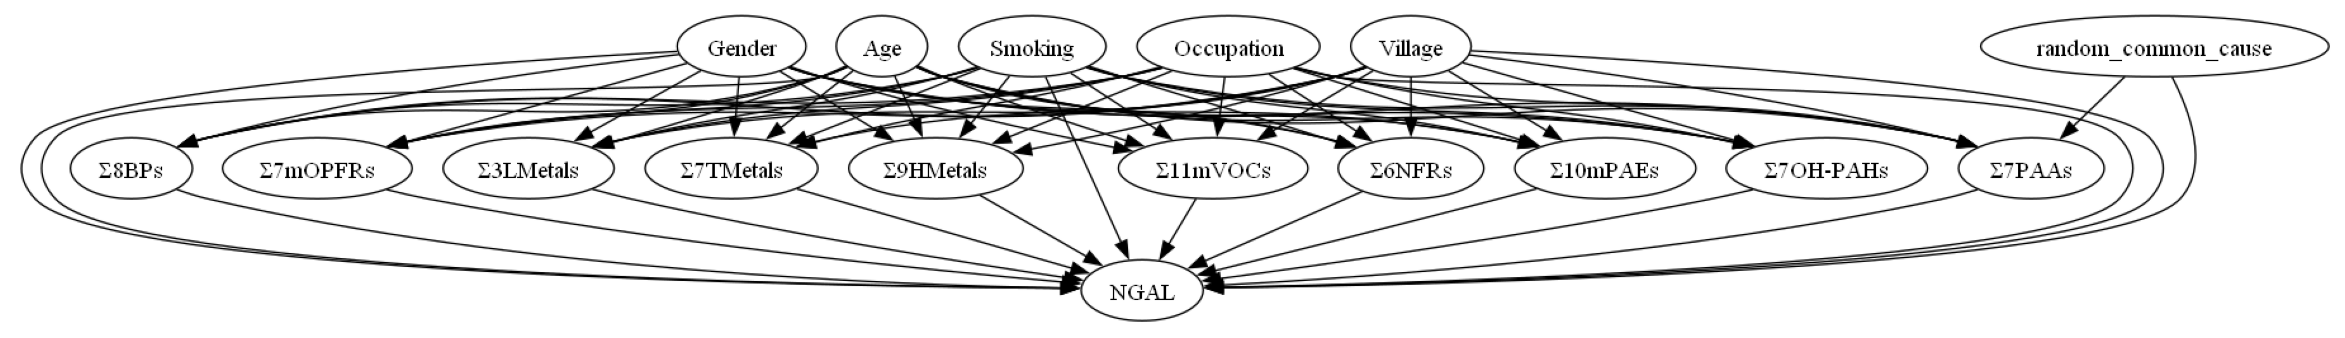

Fitting causal mechanism of node Σ9HMetals: 100%|██████████████████████████████████████| 17/17 [00:01<00:00, 11.54it/s]


In [9]:
data_target_refute3=data_target.copy()
data_target_refute3['random_common_cause'] = np.random.randn(len(data_target))
data_target_refute3

treatment_var = 'Σ7PAAs'
other_var = ['Σ11mVOCs', 'Σ6NFRs' ,  'Σ10mPAEs', 'Σ7OH-PAHs', 'Σ8BPs', 'Σ7mOPFRs' , 'Σ3LMetals', 'Σ7TMetals' , 'Σ9HMetals']
outcome_var = 'NGAL'
covariates = ['Gender',  'Age', 'Smoking', 'Occupation', 'Village', 'random_common_cause']


causal_graph = nx.DiGraph([

('Gender', outcome_var),
('Age', outcome_var),
('Smoking', outcome_var),
('Occupation', outcome_var),
('Village', outcome_var),    
(treatment_var, outcome_var),
('random_common_cause', outcome_var),
("Σ11mVOCs", outcome_var),
("Σ6NFRs", outcome_var),
("Σ10mPAEs", outcome_var),
("Σ7OH-PAHs", outcome_var),
("Σ8BPs", outcome_var),
("Σ7mOPFRs", outcome_var),
("Σ3LMetals", outcome_var),
("Σ7TMetals", outcome_var),
("Σ9HMetals", outcome_var),                       
('Gender', treatment_var),
('Age', treatment_var),
('Smoking', treatment_var),
('Occupation', treatment_var),
('Village', treatment_var),
('random_common_cause', treatment_var),                        
("Gender","Σ11mVOCs"),
("Age","Σ11mVOCs"),
("Smoking","Σ11mVOCs"),
("Occupation","Σ11mVOCs"),
("Village","Σ11mVOCs"),
("Gender","Σ6NFRs"),
("Age","Σ6NFRs"),
("Smoking","Σ6NFRs"),
("Occupation","Σ6NFRs"),
("Village","Σ6NFRs"),
("Gender","Σ10mPAEs"),
("Age","Σ10mPAEs"),
("Smoking","Σ10mPAEs"),
("Occupation","Σ10mPAEs"),
("Village","Σ10mPAEs"),
("Gender","Σ7OH-PAHs"),
("Age","Σ7OH-PAHs"),
("Smoking","Σ7OH-PAHs"),
("Occupation","Σ7OH-PAHs"),
("Village","Σ7OH-PAHs"),
("Gender","Σ8BPs"),
("Age","Σ8BPs"),
("Smoking","Σ8BPs"),
("Occupation","Σ8BPs"),
("Village","Σ8BPs"),
("Gender","Σ7mOPFRs"),
("Age","Σ7mOPFRs"),
("Smoking","Σ7mOPFRs"),
("Occupation","Σ7mOPFRs"),
("Village","Σ7mOPFRs"),
("Gender","Σ3LMetals"),
("Age","Σ3LMetals"),
("Smoking","Σ3LMetals"),
("Occupation","Σ3LMetals"),
("Village","Σ3LMetals"),
("Gender","Σ7TMetals"),
("Age","Σ7TMetals"),
("Smoking","Σ7TMetals"),
("Occupation","Σ7TMetals"),
("Village","Σ7TMetals"),
("Gender","Σ9HMetals"),
("Age","Σ9HMetals"),
("Smoking","Σ9HMetals"),
("Occupation","Σ9HMetals"),
("Village","Σ9HMetals") ])


plt.figure(figsize=(30, 30))

gcm.util.plot(causal_graph)

causal_model_refute3 = gcm.StructuralCausalModel(causal_graph)
causal_model_refute3.set_causal_mechanism(treatment_var, gcm.AdditiveNoiseModel(gcm.ml.create_random_forest_regressor()))
causal_model_refute3.set_causal_mechanism(outcome_var, gcm.AdditiveNoiseModel(gcm.ml.create_random_forest_regressor()))

for var in other_var:
    causal_model_refute3.set_causal_mechanism(var, gcm.AdditiveNoiseModel(gcm.ml.create_random_forest_regressor()))

for covariate in covariates:
    causal_model_refute3.set_causal_mechanism(covariate, gcm.EmpiricalDistribution())

gcm.fit(causal_model_refute3, data_target_refute3)

t_values_3 = np.linspace(data_target_refute3[treatment_var].min(), data_target_refute3[treatment_var].max(), 100)
y_values_3 = []
ci_lowers_3 = []
ci_uppers_3 = []

for t in t_values_3:
    samples = gcm.interventional_samples(causal_model_refute3,
                                     {treatment_var: lambda x: t},
                                     num_samples_to_draw=1000)
    y_mean_3 = np.mean(samples[outcome_var])
    y_values_3.append(y_mean_3)

    
    ci_lower_3, ci_upper_3 = stats.t.interval(
        0.95, len(samples[outcome_var])-1, loc=y_mean_3, scale=stats.sem(samples[outcome_var])
    )
    ci_lowers_3.append(ci_lower_3)
    ci_uppers_3.append(ci_upper_3)

## STEP.5 (Refutation test-4) Placebo treatment.

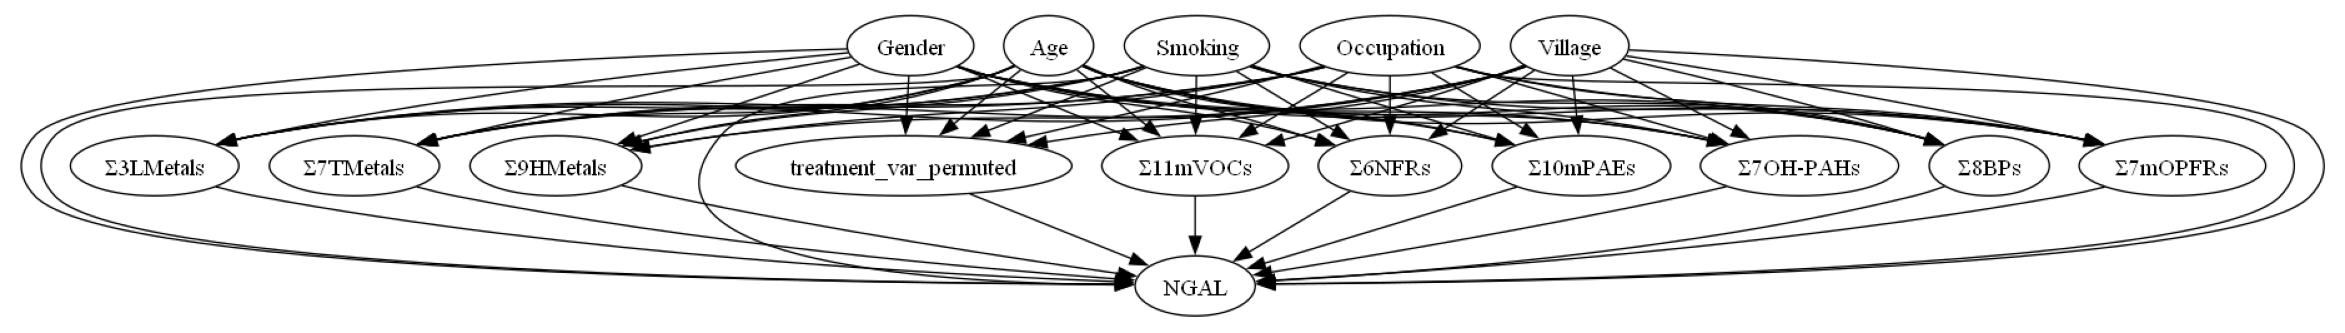

Fitting causal mechanism of node Σ9HMetals: 100%|██████████████████████████████████████| 16/16 [00:01<00:00, 12.03it/s]


In [10]:
data_target_refute4=data_target.copy()
data_target_refute4['treatment_var_permuted'] = data_target_refute4[treatment_var].sample(frac=1).values
data_target_refute4

treatment_var = "treatment_var_permuted"
other_var = ['Σ11mVOCs', 'Σ6NFRs' ,  'Σ10mPAEs', 'Σ7OH-PAHs', 'Σ8BPs',  'Σ7mOPFRs',  'Σ3LMetals','Σ7TMetals', 'Σ9HMetals']
outcome_var = 'NGAL'
covariates = ['Gender',  'Age', 'Smoking', 'Occupation', 'Village']

causal_graph = nx.DiGraph([

('Gender', outcome_var),
('Age', outcome_var),
('Smoking', outcome_var),
('Occupation', outcome_var),
('Village', outcome_var),    
(treatment_var, outcome_var),                       
("Σ11mVOCs", outcome_var),
("Σ6NFRs", outcome_var),
("Σ10mPAEs", outcome_var),
("Σ7OH-PAHs", outcome_var),
("Σ8BPs", outcome_var),
("Σ7mOPFRs", outcome_var),
("Σ3LMetals", outcome_var),
("Σ7TMetals", outcome_var),
("Σ9HMetals", outcome_var),
('Gender', treatment_var),
('Age', treatment_var),
('Smoking', treatment_var),
('Occupation', treatment_var),
('Village', treatment_var),                        
("Gender","Σ11mVOCs"),
 ("Age","Σ11mVOCs"),
 ("Smoking","Σ11mVOCs"),
 ("Occupation","Σ11mVOCs"),
 ("Village","Σ11mVOCs"),
 ("Gender","Σ6NFRs"),
 ("Age","Σ6NFRs"),
 ("Smoking","Σ6NFRs"),
 ("Occupation","Σ6NFRs"),
 ("Village","Σ6NFRs"),
 ("Gender","Σ10mPAEs"),
 ("Age","Σ10mPAEs"),
 ("Smoking","Σ10mPAEs"),
 ("Occupation","Σ10mPAEs"),
 ("Village","Σ10mPAEs"),
 ("Gender","Σ7OH-PAHs"),
 ("Age","Σ7OH-PAHs"),
 ("Smoking","Σ7OH-PAHs"),
 ("Occupation","Σ7OH-PAHs"),
 ("Village","Σ7OH-PAHs"),
 ("Gender","Σ8BPs"),
 ("Age","Σ8BPs"),
 ("Smoking","Σ8BPs"),
 ("Occupation","Σ8BPs"),
 ("Village","Σ8BPs"),
 ("Gender","Σ7mOPFRs"),
 ("Age","Σ7mOPFRs"),
 ("Smoking","Σ7mOPFRs"),
 ("Occupation","Σ7mOPFRs"),
 ("Village","Σ7mOPFRs"),
 ("Gender","Σ3LMetals"),
 ("Age","Σ3LMetals"),
 ("Smoking","Σ3LMetals"),
 ("Occupation","Σ3LMetals"),
 ("Village","Σ3LMetals"),
 ("Gender","Σ7TMetals"),
 ("Age","Σ7TMetals"),
 ("Smoking","Σ7TMetals"),
 ("Occupation","Σ7TMetals"),
 ("Village","Σ7TMetals"),
 ("Gender","Σ9HMetals"),
 ("Age","Σ9HMetals"),
 ("Smoking","Σ9HMetals"),
 ("Occupation","Σ9HMetals"),
 ("Village","Σ9HMetals")  ])


plt.figure(figsize=(30, 30))

gcm.util.plot(causal_graph)


causal_model_refute4 = gcm.StructuralCausalModel(causal_graph)
causal_model_refute4.set_causal_mechanism(treatment_var, gcm.AdditiveNoiseModel(gcm.ml.create_random_forest_regressor()))
causal_model_refute4.set_causal_mechanism(outcome_var, gcm.AdditiveNoiseModel(gcm.ml.create_random_forest_regressor()))

for var in other_var:
    causal_model_refute4.set_causal_mechanism(var, gcm.AdditiveNoiseModel(gcm.ml.create_random_forest_regressor()))

for covariate in covariates:
    causal_model_refute4.set_causal_mechanism(covariate, gcm.EmpiricalDistribution())

gcm.fit(causal_model_refute4, data_target_refute4)


t_values_4 = np.linspace(data_target_refute4[treatment_var].min(), data_target_refute4[treatment_var].max(), 100)
y_values_4 = []
ci_lowers_4 = []
ci_uppers_4 = []                    

for t in t_values_4:
    samples = gcm.interventional_samples(causal_model_refute4,
                                     {treatment_var: lambda x: t},
                                     num_samples_to_draw=1000)
    y_mean_4 = np.mean(samples[outcome_var])
    y_values_4.append(y_mean_4)

    
    ci_lower_4, ci_upper_4 = stats.t.interval(
        0.95, len(samples[outcome_var])-1, loc=y_mean_4, scale=stats.sem(samples[outcome_var])
    )
    ci_lowers_4.append(ci_lower_4)
    ci_uppers_4.append(ci_upper_4)

## STEP.6 Plot the dose-response curves.

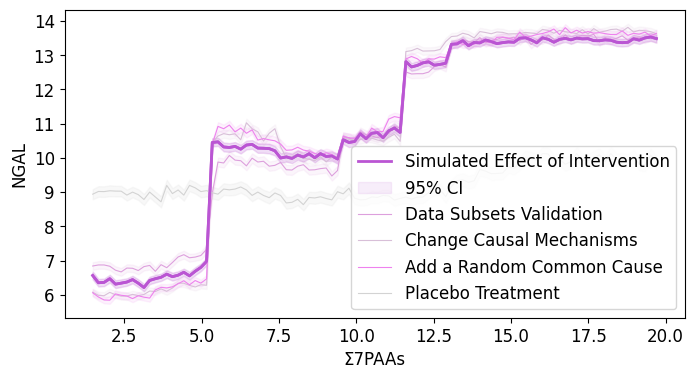

In [11]:
plt.figure(figsize=(8, 4))

plt.plot(t_values, y_values, label='Simulated Effect of Intervention', color='mediumorchid', linewidth=2)
plt.fill_between(t_values, ci_lowers, ci_uppers, color='mediumorchid', alpha=0.1, label='95% CI')

plt.plot(t_values_1, y_values_1, label='Data Subsets Validation', color='plum', linewidth=0.8)
plt.fill_between(t_values_1, ci_lowers_1, ci_uppers_1, color='plum', alpha=0.1)

plt.plot(t_values_2, y_values_2, label='Change Causal Mechanisms', color='thistle', linewidth=0.8)
plt.fill_between(t_values_2, ci_lowers_2, ci_uppers_2, color='thistle', alpha=0.1)

plt.plot(t_values_3, y_values_3, label='Add a Random Common Cause', color='violet', linewidth=0.8)
plt.fill_between(t_values_3, ci_lowers_3, ci_uppers_3, color='violet', alpha=0.1)

plt.plot(t_values_4, y_values_4, label='Placebo Treatment', color='lightgrey', linewidth=0.8)
plt.fill_between(t_values_4, ci_lowers_4, ci_uppers_4, color='lightgrey', alpha=0.15)

plt.plot(t_values, y_values, color='mediumorchid', linewidth=2)
plt.fill_between(t_values, ci_lowers, ci_uppers, color='mediumorchid', alpha=0.1)


plt.xlabel(treatment_var_ori,fontsize=12)
plt.ylabel(outcome_var,fontsize=12)
plt.tick_params(labelsize=12)
plt.legend(fontsize=12)
plt.show()

## STEP.7 T-test to compare the slope of each simulated exposure-response curve.

In [12]:
reg = LinearRegression().fit(t_values.reshape(-1, 1), y_values)
reg1 = LinearRegression().fit(t_values_1.reshape(-1, 1), y_values_1)
reg2 = LinearRegression().fit(t_values_2.reshape(-1, 1), y_values_2)
reg3 = LinearRegression().fit(t_values_3.reshape(-1, 1), y_values_3)
reg4 = LinearRegression().fit(t_values_4.reshape(-1, 1), y_values_4)

slope, intercept = reg.coef_[0], reg.intercept_
slope1, intercept1 = reg1.coef_[0], reg1.intercept_
slope2, intercept2 = reg2.coef_[0], reg2.intercept_
slope3, intercept3 = reg3.coef_[0], reg3.intercept_
slope4, intercept4 = reg4.coef_[0], reg4.intercept_

print(f"Slope of first curve: {slope}")
print(f"Slope of second curve: {slope1}")
print(f"Slope of second curve: {slope2}")
print(f"Slope of second curve: {slope3}")
print(f"Slope of second curve: {slope4}")

def compare_slopes(x1, y1, x2, y2):
    n1 = len(x1)
    n2 = len(x2)
    reg1 = LinearRegression().fit(x1.reshape(-1, 1), y1)
    reg2 = LinearRegression().fit(x2.reshape(-1, 1), y2) 
    slope1 = reg1.coef_[0]
    slope2 = reg2.coef_[0]
    residuals1 = y1 - reg1.predict(x1.reshape(-1, 1))
    residuals2 = y2 - reg2.predict(x2.reshape(-1, 1))
    se1 = np.sqrt(np.sum(residuals1**2) / (n1 - 2)) / np.sqrt(np.sum((x1 - np.mean(x1))**2))
    se2 = np.sqrt(np.sum(residuals2**2) / (n2 - 2)) / np.sqrt(np.sum((x2 - np.mean(x2))**2))
    t_value = (slope1 - slope2) / np.sqrt(se1**2 + se2**2)
    df = n1 + n2 - 4
    p_value = 2 * (1 - stats.t.cdf(np.abs(t_value), df))
    return t_value, p_value



t_value, p_value = compare_slopes(t_values, y_values, t_values_1, y_values_1)
print('\n')
print(f"Data Subsets Validation：T-value: {t_value}")
print(f"Data Subsets Validation：P-value: {p_value}")
if p_value < 0.05:
    print("Data Subsets Validation：The trends of the two curves are significantly different (p < 0.05).")
else:
    print("Data Subsets Validation：The trends of the two curves are not significantly different (p >= 0.05).")


t_value, p_value = compare_slopes(t_values, y_values, t_values_2, y_values_2)
print('\n')
print(f"Change Causal Mechanisms：T-value: {t_value}")
print(f"Change Causal Mechanisms：P-value: {p_value}")
if p_value < 0.05:
    print("Change Causal Mechanisms：The trends of the two curves are significantly different (p < 0.05).")
else:
    print("Change Causal Mechanisms：The trends of the two curves are not significantly different (p >= 0.05).")


t_value, p_value = compare_slopes(t_values, y_values, t_values_3, y_values_3)
print('\n')
print(f"Add a Random Common Cause：T-value: {t_value}")
print(f"Add a Random Common Cause：P-value: {p_value}")
if p_value < 0.05:
    print("Add a Random Common Cause：The trends of the two curves are significantly different (p < 0.05).")
else:
    print("Add a Random Common Cause：The trends of the two curves are not significantly different (p >= 0.05).")


t_value, p_value = compare_slopes(t_values, y_values, t_values_4, y_values_4)
print('\n')
print(f"Placebo Treatment：T-value: {t_value}")
print(f"Placebo Treatment：P-value: {p_value}")
if p_value < 0.05:
    print("Placebo Treatment：The trends of the two curves are significantly different (p < 0.05).")
else:
    print("Placebo Treatment：The trends of the two curves are not significantly different (p >= 0.05).")

Slope of first curve: 0.4577291645059272
Slope of second curve: 0.4513804739079515
Slope of second curve: 0.4926266214113884
Slope of second curve: 0.4841620906281187
Slope of second curve: 0.06834295162805103


Data Subsets Validation：T-value: 0.27219518360004874
Data Subsets Validation：P-value: 0.7857584696901005
Data Subsets Validation：The trends of the two curves are not significantly different (p >= 0.05).


Change Causal Mechanisms：T-value: -1.2319050062708654
Change Causal Mechanisms：P-value: 0.21946044767621542
Change Causal Mechanisms：The trends of the two curves are not significantly different (p >= 0.05).


Add a Random Common Cause：T-value: -0.9517294508994888
Add a Random Common Cause：P-value: 0.3424063692110253
Add a Random Common Cause：The trends of the two curves are not significantly different (p >= 0.05).


Placebo Treatment：T-value: 20.54467910484086
Placebo Treatment：P-value: 0.0
Placebo Treatment：The trends of the two curves are significantly different (p < 0.05).
